In [1]:
import os 
from DeepST import run
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from anndata import AnnData
from PIL import Image
import scipy

simulate

In [2]:
def read_simulate(feat_file, 
                  coord_file,
                 library_id = None,
                 scale = None,
                 quality = "hires",
                 spot_diameter_fullres= 50,
                 background_color = "white",):

    count = pd.read_csv(feat_file,header=0,index_col=0)
    meta = pd.read_csv(coord_file,header=0,index_col=0)
    meta=meta.loc[count.index,:]
    adata = AnnData(count)
    adata.obs["index"] = meta.index

    if scale == None:
        max_coor = np.max(meta[["x", "y"]].values)
        scale = 2000 / max_coor

    adata.obs["imagecol"] = meta["x"].values * scale
    adata.obs["imagerow"] = meta["y"].values * scale
    # Create image
    max_size = np.max([adata.obs["imagecol"].max(), adata.obs["imagerow"].max()])
    max_size = int(max_size + 0.1 * max_size)

    if background_color == "black":
        image = Image.new("RGBA", (max_size, max_size), (0, 0, 0, 0))
    else:
        image = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    imgarr = np.array(image)
    if library_id is None:
        library_id = "Slide-seq"

    adata.uns["spatial"] = {}
    adata.uns["spatial"][library_id] = {}
    adata.uns["spatial"][library_id]["images"] = {}
    adata.uns["spatial"][library_id]["images"][quality] = imgarr
    adata.uns["spatial"][library_id]["use_quality"] = quality
    adata.uns["spatial"][library_id]["scalefactors"] = {}
    adata.uns["spatial"][library_id]["scalefactors"][
        "tissue_" + quality + "_scalef"] = scale

    adata.uns["spatial"][library_id]["scalefactors"][
        "spot_diameter_fullres"
    ] = spot_diameter_fullres
    adata.obsm["spatial"] = meta[["x", "y"]].values
    return adata

In [3]:
save_path = "/data02/tguo/space_batch_effect/simulate/methods/" 
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000,
             platform = "slideSeq",use_gpu=False)

In [4]:
dirs="/data02/tguo/space_batch_effect/simulate/"
batch_sim="_1"
types=""
flags=batch_sim+types
data_name=['Batch1','Batch2','Batch3']
B=2
from adj import graph, combine_graph_dict


scale=None
background_color = "white"
quality = "hires"
library_id='slice1'
spot_diameter_fullres= 1
feat_file=dirs+"gtt_input/feat1"+flags+".csv"
coord_file=dirs+"gtt_input/coord1"+flags+".csv"
current_adata=read_simulate(feat_file, coord_file,library_id,scale,quality,spot_diameter_fullres,background_color)
current_adata = deepen._get_augment(current_adata,weights = "weights_matrix_nomd")
current_graph_dict = deepen._get_graph(current_adata.obsm["spatial"],distType = "Radius",k = 10,rad_cutoff = 1)
current_adata.obs['batch_name'] = data_name[0]
current_adata.obs['batch_name'] = current_adata.obs['batch_name'].astype('category')
adata = current_adata
graph_dict = current_graph_dict

for i in np.arange(1,B):
    feat_file=dirs+"gtt_input/feat"+str(i+1)+flags+".csv"
    coord_file=dirs+"gtt_input/coord"+str(i+1)+flags+".csv"
    current_adata=read_simulate(feat_file, coord_file,library_id,scale,quality,spot_diameter_fullres,background_color)
    current_adata = deepen._get_augment(current_adata,weights = "weights_matrix_nomd")
    current_graph_dict = deepen._get_graph(current_adata.obsm["spatial"],distType = "Radius",k = 10,rad_cutoff = 1)
    current_adata.obs['batch_name'] = data_name[0]
    current_adata.obs['batch_name'] = current_adata.obs['batch_name'].astype('category')
    var_names = adata.var_names.intersection(current_adata.var_names)
    adata = adata[:, var_names]
    current_adata = current_adata[:, var_names]
    adata = adata.concatenate(current_adata)
    graph_dict = combine_graph_dict(graph_dict, current_graph_dict)
    
domains = np.array(
            pd.Categorical(
            adata.obs['batch_name'],
            categories=np.unique(adata.obs['batch_name']),).codes,
            dtype=np.int64,
        )
deepen.data_name = data_name
adata = deepen._fit(adata, graph_dict, domains, pretrain = True)
embed=adata.obsm['DeepST_embed']
cells=[i.split('-')[0] for i in adata.obs_names]
embed_names=['DeepST-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=cells,columns=embed_names)
embed.to_csv(dirs+"methods/DeepST_mat"+flags+".txt")

/tmp/ipykernel_11841/2041198199.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(count)


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_nomd'] !


Find adjacent spots of each spot: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Augment gene representation is Done!
20.4160 neighbors per cell on average.
Step 2: Graph computing is Done!
Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0


/tmp/ipykernel_11841/2041198199.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(count)


Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_nomd'] !


Find adjacent spots of each spot: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Augment gene representation is Done!
21.3400 neighbors per cell on average.
Step 2: Graph computing is Done!


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：0.5955 GB
Total time: 22.33 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


DLPFC

In [2]:
from utils_func import *
from his_feat import image_feature, image_crop
from adj import graph, combine_graph_dict

data_path = "/data02/tguo/space_batch_effect/human_DLPFC_10x/scanpy_file" 
sample_name=np.array(['151507','151508','151509','151510','151669','151670','151671','151672','151673','151674','151675','151676'])
data_name_list = sample_name[0:12]
save_path = "/data02/tguo/space_batch_effect/human_DLPFC_10x/methods/" 
n_domains = 7
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000,
             platform = "Visium",use_gpu=False)


character = "spatial"
verbose = False
adjacent_weight = 0.3
neighbour_k = 4
weights = "weights_matrix_all"
spatial_k = 30
distType = "Radius"
k = 12
rad_cutoff = 150
data_name=data_name_list

i=3
current_adata = deepen._get_adata(data_path, data_name[i])
current_adata = deepen._get_augment(current_adata)
current_graph_dict = deepen._get_graph(current_adata.obsm[character])
current_graph_dict = deepen._get_graph(current_adata.obsm[character])
current_adata.X=current_adata.obsm['augment_gene_data']
current_adata.obs['batch_name'] = data_name[i]
current_adata.obs['batch_name'] = current_adata.obs['batch_name'].astype('category')
adata = current_adata
graph_dict = current_graph_dict
adata
adata.write("s"+str(i+1)+".h5ad")
graph_dict
np.save("s"+str(i+1)+".npy",graph_dict)


# adata=sc.read("s1.h5ad")
# adata.var_names=[i.upper() for i in adata.var_names]
# mat=pd.DataFrame(adata.obsm['augment_gene_data'],index=adata.obs_names,columns=adata.var_names)
# for i in np.arange(2,13):
#     current_adata=sc.read("s"+str(i)+".h5ad")
#     current_adata.var_names=[i.upper() for i in current_adata.var_names]
#     current_mat=pd.DataFrame(current_adata.obsm['augment_gene_data'],index=current_adata.obs_names,columns=current_adata.var_names)
#     var_names = adata.var_names.intersection(current_adata.var_names)
#     adata = adata[:, var_names]
#     current_adata = current_adata[:, var_names]
#     adata = adata.concatenate(current_adata)
#     mat=mat.loc[:,var_names]
#     current_mat=current_mat.loc[:,var_names]
#     mat=pd.concat((mat,current_mat),axis=0)
# adata.obsm['augment_gene_data']=mat.values
# adata.write("DLPFC.h5ad")

/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Tiling image: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Extract image feature: 100%|████████████

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 32.79542511868796
Gene correlation calculting Done!
Morphological similarity calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Augment gene representation is Done!
5.8692 neighbors per cell on average.
Step 2: Graph computing is Done!
5.8692 neighbors per cell on average.
Step 2: Graph computing is Done!


In [4]:
data_path = "/data02/tguo/space_batch_effect/human_DLPFC_10x/scanpy_file" 
sample_name=np.array(['151507','151508','151509','151510','151669','151670','151671','151672','151673','151674','151675','151676'])
IDX=[[0,1],[1,2],[2,3],[4,5],[5,6],[6,7],[8,9],[9,10],[10,11]]
for idx in np.arange(1,len(IDX)):
    
    data_name_list = sample_name[IDX[idx]]
    save_path = "/data02/tguo/space_batch_effect/human_DLPFC_10x/methods/" 
    n_domains = 7
    deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000,
                 platform = "Visium",use_gpu=True)

    from adj import graph, combine_graph_dict
    import scanpy as sc
    import pandas as pd

    graph_dict=np.load("s"+str(IDX[idx][0]+1)+".npy", allow_pickle=True).item()
    adata=sc.read("s"+str(IDX[idx][0]+1)+".h5ad")
    adata.var_names=[i.upper() for i in adata.var_names]
    mat=pd.DataFrame(adata.obsm['augment_gene_data'],index=adata.obs_names,columns=adata.var_names)
    for i in np.arange(IDX[idx][1]+1,IDX[idx][1]+2):
        current_adata=sc.read("s"+str(i)+".h5ad")
        current_adata.var_names=[i.upper() for i in current_adata.var_names]
        current_mat=pd.DataFrame(current_adata.obsm['augment_gene_data'],index=current_adata.obs_names,columns=current_adata.var_names)
        var_names = adata.var_names.intersection(current_adata.var_names)
        adata = adata[:, var_names]
        current_adata = current_adata[:, var_names]
        adata = adata.concatenate(current_adata)
        mat=mat.loc[:,var_names]
        current_mat=current_mat.loc[:,var_names]
        mat=pd.concat((mat,current_mat),axis=0)
        current_graph_dict=np.load("s"+str(i)+".npy", allow_pickle=True).item()
        graph_dict = combine_graph_dict(graph_dict, current_graph_dict)
    adata.obsm['augment_gene_data']=mat.values

    # adata=sc.read("DLPFC.h5ad")
    domains = np.array(
                pd.Categorical(
                adata.obs['batch_name'],
                categories=np.unique(adata.obs['batch_name']),).codes,
                dtype=np.int64,
            )
    deepen.data_name = data_name_list

    adata = deepen._fit(adata, graph_dict, domains, pretrain = True)
    # # adata, graph_dict, domains = deepen._get_multiple_adata(data_path, data_name_list)
    # # adata = deepen._fit(adata, graph_dict, domains, pretrain = True)

    dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
    samples=data_name_list
    flags1=str(samples[0])
    flags='_'+str(samples[0])
    for i in range(1,len(samples)):
        flags1=flags1+'-'+str(samples[i])
        flags=flags+"_"+str(samples[i])
    meta=pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[0])+"_label.txt",header=0,index_col=0)
    for i in np.arange(1,len(samples)):
        meta=pd.concat((meta,pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_label.txt",header=0,index_col=0)))

    aa=adata.obs['batch_name']
    allindex=adata.obs_names
    index=np.array([aa[i]+'-'+allindex[i].split('-')[0]+'-'+allindex[i].split('-')[1] for i in np.arange(len(allindex))])
    embed=adata.obsm['DeepST_embed']
    names=['DeepST-'+str(i) for i in np.arange(embed.shape[1])]
    embed=pd.DataFrame(embed,index=index,columns=names)
    # clust=pd.DataFrame(adata.obs['DeepST_refine_domain'].values,index=index,columns=['DeepST_refine_domain'])
    # embed1=embed.loc[meta.index,:].values
    # clust1=clust.loc[meta.index,:].values
    embed.to_csv(dirs+"methods/DeepST_mat"+flags+".txt")

/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：36.5116 GB
Total time: 4.37 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：33.3456 GB
Total time: 4.61 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：46.9249 GB
Total time: 4.46 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：62.5953 GB
Total time: 4.55 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：79.1894 GB
Total time: 4.86 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：44.8032 GB
Total time: 5.23 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：59.3545 GB
Total time: 7.16 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：73.4218 GB
Total time: 8.75 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


Coronal mouse brain

In [20]:
data_path = "/data02/tguo/space_batch_effect/Hippo/origin" 
data_name_list = ['10X_DAPI','10X_FFPE','10X_Normal']
save_path = "/data02/tguo/space_batch_effect/Hippo/methods/" 
n_domains = 12 
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000,platform = "Visium")
adata, graph_dict, domains = deepen._get_multiple_adata(data_path, data_name_list,distType='euclidean',neighbour_k = 6,k=6,spatial_k=30)
adata = deepen._fit(adata, graph_dict, domains, pretrain = True)
adata = deepen._get_cluster_data(adata, n_domains = n_domains, priori=True)

dirs = "/data02/tguo/space_batch_effect/Hippo/" 
flags=''
for i in np.arange(len(data_name_list)):
    flags=flags+'_'+str(data_name_list[i])
embed=adata.obsm['DeepST_embed']
cells=[i.split('-')[0]+'-'+i.split('-')[1] for i in adata.obs_names]
for i in np.arange(len(cells)):
    cells[i]=adata.obs['batch_name'].tolist()[i]+'-'+cells[i]
embed_names=['DeepST-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=cells,columns=embed_names)
embed.to_csv(dirs+"methods/DeepST_mat"+flags+".txt")

Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：26.3329 GB
Total time: 9.12 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


KeyboardInterrupt: 

saggital mouse brain

In [2]:
data_path="/data02/tguo/space_batch_effect/mouse_brain/origin/origin"
data_name_list=["all_posterior1","all_posterior2","all_anterior1","all_anterior2"]
save_path = "/data02/tguo/space_batch_effect/mouse_brain/methods/" 

deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000,platform = "Visium")
from utils_func import *
from his_feat import image_feature, image_crop
from adj import graph, combine_graph_dict
character = "spatial"
verbose = False
adjacent_weight = 0.3
neighbour_k = 4
weights = "weights_matrix_all"
spatial_k = 30
distType = "Radius"
k = 12
rad_cutoff = 150
data_name=data_name_list



i=4
current_adata = deepen._get_adata(data_path, data_name[i])
current_adata = deepen._get_augment(current_adata)
current_graph_dict = deepen._get_graph(current_adata.obsm[character])
current_graph_dict = deepen._get_graph(current_adata.obsm[character])
current_adata.X=current_adata.obsm['augment_gene_data']
current_adata.obs['batch_name'] = data_name[i]
current_adata.obs['batch_name'] = current_adata.obs['batch_name'].astype('category')
adata = current_adata
graph_dict = current_graph_dict
adata
adata.write("s"+str(i+1)+".h5ad")
graph_dict
np.save("s"+str(i+1)+".npy",graph_dict)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/data02/tguo/space_batch_effect/mouse_brain/origin/origin/posterior1/filtered_feature_bc_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
data_path="/data02/tguo/space_batch_effect/mouse_brain/origin/origin"
data_name_list=["all_posterior1","all_posterior2","all_anterior1","all_anterior2"]
# data_name_list=["posterior1","posterior2"]
data_name_list=["anterior1","anterior2"]
save_path = "/data02/tguo/space_batch_effect/mouse_brain/methods/" 
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000,platform = "Visium")

from adj import graph, combine_graph_dict
import scanpy as sc
import pandas as pd
graph_dict=np.load("s3.npy", allow_pickle=True).item()
adata=sc.read("s3.h5ad")
adata.var_names=[i.upper() for i in adata.var_names]
mat=pd.DataFrame(adata.obsm['augment_gene_data'],index=adata.obs_names,columns=adata.var_names)
for i in np.arange(4,5):
    current_adata=sc.read("s"+str(i)+".h5ad")
    current_adata.var_names=[i.upper() for i in current_adata.var_names]
    current_mat=pd.DataFrame(current_adata.obsm['augment_gene_data'],index=current_adata.obs_names,columns=current_adata.var_names)
    var_names = adata.var_names.intersection(current_adata.var_names)
    adata = adata[:, var_names]
    current_adata = current_adata[:, var_names]
    adata = adata.concatenate(current_adata)
    mat=mat.loc[:,var_names]
    current_mat=current_mat.loc[:,var_names]
    mat=pd.concat((mat,current_mat),axis=0)
    current_graph_dict=np.load("s"+str(i)+".npy", allow_pickle=True).item()
    graph_dict = combine_graph_dict(graph_dict, current_graph_dict)
adata.obsm['augment_gene_data']=mat.values

domains = np.array(
            pd.Categorical(
            adata.obs['batch_name'],
            categories=np.unique(adata.obs['batch_name']),).codes,
            dtype=np.int64,
        )
deepen.data_name = data_name_list
# adata, graph_dict, domains = deepen._get_multiple_adata(data_path, data_name_list,distType='euclidean',neighbour_k = 6,k=6,spatial_k=30)
adata = deepen._fit(adata, graph_dict, domains, pretrain = True)


dirs = "/data02/tguo/space_batch_effect/mouse_brain/" 
flags=''
for i in np.arange(len(data_name_list)):
    flags=flags+'_'+str(data_name_list[i])
embed=adata.obsm['DeepST_embed']
cells=[i.split('-')[0]+'-'+i.split('-')[1] for i in adata.obs_names]
for i in np.arange(len(cells)):
    cells[i]=adata.obs['batch_name'].tolist()[i]+'-'+cells[i]
cells=[i.split('_')[1] for i in cells]
cells=[i.split('-')[0]+'-'+i.split('-')[1]+'.'+i.split('-')[2] for i in cells]
embed_names=['DeepST-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=cells,columns=embed_names)
embed.to_csv(dirs+"methods/DeepST_mat"+flags+".txt")

/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
DeepST trains a final model:   0%|                                                                                                                          [ time left: ? ]/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
DeepST trains a final model: |                                                                                                                          [ time left: 00:00 ]


Step 3: DeepST training has been Done!
Current memory usage：25.0949 GB
Total time: 3.32 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


mouse ob

In [10]:
def read_SlideSeq(count_files,location_files,
                 library_id = None,
                 scale = None,
                 quality = "hires",
                 spot_diameter_fullres= 50,
                 background_color = "white"):

    count = pd.read_csv(count_files,index_col=0,header=0)
    meta = pd.read_csv(location_files,index_col=0,header=0)
    meta.columns=['x','y']

    adata = AnnData(count)
#     adata.X=scipy.sparse.csr_matrix(adata.X)

    adata.obs["index"] = adata.obs_names

    if scale == None:
        max_coor = np.max(meta[["x", "y"]].values)
        scale = 2000 / max_coor

    adata.obs["imagecol"] = meta["x"].values * scale
    adata.obs["imagerow"] = meta["y"].values * scale

    # Create image
    max_size = np.max([adata.obs["imagecol"].max(), adata.obs["imagerow"].max()])
    max_size = int(max_size + 0.1 * max_size)

    if background_color == "black":
        image = Image.new("RGBA", (max_size, max_size), (0, 0, 0, 0))
    else:
        image = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    imgarr = np.array(image)

    if library_id is None:
        library_id = "Slide-seq"

    adata.uns["spatial"] = {}
    adata.uns["spatial"][library_id] = {}
    adata.uns["spatial"][library_id]["images"] = {}
    adata.uns["spatial"][library_id]["images"][quality] = imgarr
    adata.uns["spatial"][library_id]["use_quality"] = quality
    adata.uns["spatial"][library_id]["scalefactors"] = {}
    adata.uns["spatial"][library_id]["scalefactors"][
        "tissue_" + quality + "_scalef"] = scale

    adata.uns["spatial"][library_id]["scalefactors"][
        "spot_diameter_fullres"
    ] = spot_diameter_fullres
    adata.obsm["spatial"] = meta[["x", "y"]].values

    return adata

def read_stereoSeq(count_files,location_files,
                is_sparse=True,
                library_id=None,
                scale=None,
                quality="hires",
                spot_diameter_fullres=1,
                background_color="white",):

    from scipy import sparse
    count=pd.read_csv(count_files,index_col=0,header=0)
    pos=pd.read_csv(location_files,index_col=0,header=0)
    pos=pos.loc[count.index,:]
    adata = AnnData(count)
#     adata.X=scipy.sparse.csr_matrix(adata.X)
    adata.obsm['spatial'] = pos.values
    if scale == None:
        max_coor = np.max(adata.obsm["spatial"])
        scale = 20 / max_coor

    adata.obs["imagecol"] = adata.obsm["spatial"][:, 0] * scale
    adata.obs["imagerow"] = adata.obsm["spatial"][:, 1] * scale

    # Create image
    max_size = np.max([adata.obs["imagecol"].max(), adata.obs["imagerow"].max()])
    max_size = int(max_size + 0.1 * max_size)
    if background_color == "black":
        image = Image.new("RGB", (max_size, max_size), (0, 0, 0, 0))
    else:
        image = Image.new("RGB", (max_size, max_size), (255, 255, 255, 255))
    imgarr = np.array(image)

    if library_id is None:
        library_id = "StereoSeq"

    adata.uns["spatial"] = {}
    adata.uns["spatial"][library_id] = {}
    adata.uns["spatial"][library_id]["images"] = {}
    adata.uns["spatial"][library_id]["images"][quality] = imgarr
    adata.uns["spatial"][library_id]["use_quality"] = quality
    adata.uns["spatial"][library_id]["scalefactors"] = {}
    adata.uns["spatial"][library_id]["scalefactors"]["tissue_" + quality + "_scalef"] = scale
    adata.uns["spatial"][library_id]["scalefactors"]["spot_diameter_fullres"] = spot_diameter_fullres

    return adata

In [ ]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/gtt_input/"
samples=['BGI','SlideV2']
save_path = "/data02/tguo/space_batch_effect/mouse_OB/methods/" 
deepen = run(model_path=dirs,save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000, platform = "stereoSeq")

# count_files=dirs+"SlideV2_allgene_mat.csv"
# location_files=dirs+"SlideV2_coord.csv"
# adata1=read_SlideSeq(count_files,location_files,
#                  library_id = None,
#                  scale = None,
#                  quality = "hires",
#                  spot_diameter_fullres= 50,
#                  background_color = "white")
# adata1 = deepen._get_augment(adata1,weights = "weights_matrix_nomd")
# graph_dict1=deepen._get_graph(adata1.obsm["spatial"],distType = "Radius",k = 10,rad_cutoff = 50)
# adata1.obs['batch_name'] = samples[1]
# adata1.obs['batch_name'] = adata1.obs['batch_name'].astype('category')
# adata1.write(samples[1]+".h5ad")
# np.save(samples[1]+".npy",graph_dict1)

count_files=dirs+"BGI_allgene_mat.csv"
location_files=dirs+"BGI_coord.csv"
adata2=read_stereoSeq(count_files,location_files,
                is_sparse=True,
                library_id=None,
                scale=None,
                quality="hires",
                spot_diameter_fullres=1,
                background_color="white")
adata2 = deepen._get_augment(adata2,weights = "weights_matrix_nomd")
graph_dict2=deepen._get_graph(adata2.obsm["spatial"],distType = "Radius",k = 10,rad_cutoff = 2)
adata2.obs['batch_name'] = samples[0]
adata2.obs['batch_name'] = adata2.obs['batch_name'].astype('category')
adata2.write(samples[0]+"_bin50.h5ad")
np.save(samples[0]+"_bin50.npy",graph_dict2)

/tmp/ipykernel_10793/1685444421.py:65: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(count)


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0


In [ ]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/gtt_input/BGI_SlideV2_10X/"
samples=['BGI','SlideV2']
save_path = "/data02/tguo/space_batch_effect/mouse_OB/methods/" 
deepen = run(model_path=dirs,save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000, platform = "slideSeq",use_gpu=False)

from adj import graph, combine_graph_dict
var_names = adata1.var_names.intersection(adata2.var_names)
adata1 = adata1[:, var_names]
adata2 = adata2[:, var_names]
adata = adata1.concatenate(adata2)
graph_dict = combine_graph_dict(graph_dict1, graph_dict2)

domains = np.array(
            pd.Categorical(
            adata.obs['batch_name'],
            categories=np.unique(adata.obs['batch_name']),).codes,
            dtype=np.int64,
        )
deepen.data_name = samples
adata = deepen._fit(adata, graph_dict, domains, pretrain = True)

dirs = "/data02/tguo/space_batch_effect/mouse_OB/" 
flags=''
for i in np.arange(len(samples)):
    flags=flags+'_'+str(samples[i])
embed=adata.obsm['DeepST_embed']

idx1=np.where(adata.obs['batch_name']=='BGI')[0]
idx2=np.where(adata.obs['batch_name']=='SlideV2')[0]
cells=np.array([i.split('-')[0]+'-'+i.split('-')[1] for i in adata.obs_names])
a=cells[idx1]
cells[idx1]=np.array([i.split('-')[0] for i in a])
embed_names=['DeepST-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=cells,columns=embed_names)
embed=pd.concat((embed.iloc[idx1,:],embed.iloc[idx2,:]))
embed.to_csv(dirs+"methods/DeepST_mat"+flags+".txt")

10X and Stereo-seq

In [2]:
samples=['10X','BGI']
save_path = "/data02/tguo/space_batch_effect/mouse_OB/methods/" 
data_path="/data02/tguo/space_batch_effect/mouse_OB/origin/"
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, pca_n_comps = 200,pre_epochs = 800, epochs = 1000, platform = "Visium",use_gpu=False)
adata = deepen._get_adata(data_path, "10X_Visium")
adata = deepen._get_augment(adata, adjacent_weight = 0.3, neighbour_k = 4)
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType="BallTree", k=12)
adata.write(samples[0]+".h5ad")
np.save(samples[0]+".npy",graph_dict)

data_path = "/data02/tguo/space_batch_effect/mouse_OB/origin/" 
data_name = 'Dataset1_LiuLongQi_MouseOlfactoryBulb' 
save_path = "/data02/tguo/space_batch_effect/mouse_OB/methods/"
n_domains = 8 
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, platform = "stereoSeq",pca_n_comps = 200,pre_epochs = 800,epochs = 1000)
adata, graph_dict= deepen._get_single_adata(data_path, data_name, weights="weights_matrix_nomd") 
adata.write(samples[1]+".h5ad")
np.save(samples[1]+".npy",graph_dict)

In [11]:
samples=['10X','BGI']
dirs = "/data02/tguo/space_batch_effect/mouse_OB/methods/" 
deepen = run(model_path='resnet50-0676ba61.pth',save_path = dirs, pca_n_comps = 200,pre_epochs = 800, epochs = 1000, platform = "slideSeq",use_gpu=False)



from adj import graph, combine_graph_dict
from adj import graph, combine_graph_dict
import scanpy as sc
import pandas as pd
graph_dict1=np.load(samples[0]+".npy", allow_pickle=True).item()
adata1=sc.read(samples[0]+".h5ad")
graph_dict2=np.load(samples[1]+"bin"+str(bin_size)+".npy", allow_pickle=True).item()
adata2=sc.read(samples[1]+"bin"+str(bin_size)+".h5ad")
var_names = adata1.var_names.intersection(adata2.var_names)
adata1 = adata1[:, var_names]
adata2 = adata2[:, var_names]
adata1.obs['batch_name']=samples[0]
adata2.obs['batch_name']=samples[1]
adata = adata1.concatenate(adata2)
graph_dict = combine_graph_dict(graph_dict1, graph_dict2)

domains = np.array(
            pd.Categorical(
            adata.obs['batch_name'],
            categories=np.unique(adata.obs['batch_name']),).codes,
            dtype=np.int64,
        )
deepen.data_name = samples
adata = deepen._fit(adata, graph_dict, domains, pretrain = True)

embed=adata.obsm['DeepST_embed']
idx1=np.where(adata.obs['batch_name']=='10X')[0]
idx2=np.where(adata.obs['batch_name']=='BGI')[0]
cells=np.array([i.split('-')[0]+'-'+i.split('-')[1] for i in adata.obs_names])
a=cells[idx2]
cells[idx2]=['Spot-'+x for x in cells[idx2]]
embed_names=['DeepST-'+str(i) for i in np.arange(embed.shape[1])]
embed=pd.DataFrame(embed,index=cells,columns=embed_names)
embed=pd.concat((embed.iloc[idx1,:],embed.iloc[idx2,:]))
embed.to_csv(dirs+"DeepST_mat_10X_BGI-bin"+str(bin_size)+".txt")

/tmp/ipykernel_13797/3541954124.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs['batch_name']=samples[0]
/tmp/ipykernel_13797/3541954124.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['batch_name']=samples[1]
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not b

In [2]:
data_path = "/data02/tguo/space_batch_effect/mouse_OB/origin/" 
data_name = 'Dataset1_LiuLongQi_MouseOlfactoryBulb' 
save_path = "/data02/tguo/space_batch_effect/mouse_OB/methods/"
n_domains = 8 
deepen = run(model_path='resnet50-0676ba61.pth',save_path = save_path, platform = "stereoSeq",pca_n_comps = 200,pre_epochs = 800,epochs = 1000)
# adata, graph_dict= deepen._get_single_adata(data_path, data_name, weights="weights_matrix_nomd") 
# adata = deepen._fit(adata, graph_dict, pretrain = False)
# adata = deepen._get_cluster_data(adata, n_domains = n_domains, priori=True)
# ######## spatial domains #####
# deepen.plot_domains(adata, data_name)
# ######## UMAP #####
# deepen.plot_umap(adata, data_name)

In [17]:
path="/data02/tguo/space_batch_effect/mouse_OB/origin/Dataset1_LiuLongQi_MouseOlfactoryBulb" 
bin_size=50
is_sparse=True
library_id=None
scale=None
quality="hires"
spot_diameter_fullres=1
background_color="white"

from scipy import sparse
count = pd.read_csv(os.path.join(path, "count.txt"), sep='\t', comment='#', header=0)
count.dropna(inplace=True)
if "MID" in count.columns:
    count.rename(columns={"MID": "UMICount"}, inplace=True)
count['x1'] = (count['x'] / bin_size).astype(np.int32)
count['y1'] = (count['y'] / bin_size).astype(np.int32)
count['pos'] = count['x1'].astype(str) + "-" + count['y1'].astype(str)
bin_data = count.groupby(['pos', 'geneID'])['UMICount'].sum()
cells = set(x[0] for x in bin_data.index)
genes = set(x[1] for x in bin_data.index)
cellsdic = dict(zip(cells, range(0, len(cells))))
genesdic = dict(zip(genes, range(0, len(genes))))
rows = [cellsdic[x[0]] for x in bin_data.index]
cols = [genesdic[x[1]] for x in bin_data.index]
exp_matrix = sparse.csr_matrix((bin_data.values, (rows, cols))) if is_sparse else \
             sparse.csr_matrix((bin_data.values, (rows, cols))).toarray()
obs = pd.DataFrame(index=list(cells))
var = pd.DataFrame(index=list(genes))
adata = AnnData(X=exp_matrix, obs=obs, var=var)
pos = np.array(list(adata.obs.index.str.split('-', expand=True)), dtype=np.int)
adata.obsm['spatial'] = pos

if scale == None:
    max_coor = np.max(adata.obsm["spatial"])
    scale = 20 / max_coor

adata.obs["imagecol"] = adata.obsm["spatial"][:, 0] * scale
adata.obs["imagerow"] = adata.obsm["spatial"][:, 1] * scale

# Create image
max_size = np.max([adata.obs["imagecol"].max(), adata.obs["imagerow"].max()])
max_size = int(max_size + 0.1 * max_size)
if background_color == "black":
    image = Image.new("RGB", (max_size, max_size), (0, 0, 0, 0))
else:
    image = Image.new("RGB", (max_size, max_size), (255, 255, 255, 255))
imgarr = np.array(image)

if library_id is None:
    library_id = "StereoSeq"

adata.uns["spatial"] = {}
adata.uns["spatial"][library_id] = {}
adata.uns["spatial"][library_id]["images"] = {}
adata.uns["spatial"][library_id]["images"][quality] = imgarr
adata.uns["spatial"][library_id]["use_quality"] = quality
adata.uns["spatial"][library_id]["scalefactors"] = {}
adata.uns["spatial"][library_id]["scalefactors"]["tissue_" + quality + "_scalef"] = scale
adata.uns["spatial"][library_id]["scalefactors"]["spot_diameter_fullres"] = spot_diameter_fullres

adata.X=np.array(adata.X.todense())
adata

/tmp/ipykernel_25543/1766217428.py:29: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X=exp_matrix, obs=obs, var=var)
/tmp/ipykernel_25543/1766217428.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pos = np.array(list(adata.obs.index.str.split('-', expand=True)), dtype=np.int)


AnnData object with n_obs × n_vars = 8827 × 27925
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'

In [18]:
adata.obsm['spatial']

array([[1344, 1533],
       [1358, 1592],
       [1381, 1578],
       ...,
       [1346, 1561],
       [1342, 1538],
       [1343, 1610]])

In [11]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
cells=['Stereo-'+str(x) for x in adata.obs_names]
mat=pd.DataFrame(adata.X,index=cells,columns=adata.var_names)
coord=pd.DataFrame(adata.obsm['spatial'],index=cells,columns=['x','y'])
meta=pd.DataFrame('Stereo',index=cells,columns=['batch'])
mat.to_csv(dirs+"gtt_input/Stereo_bin34_mat_allgene.csv")
meta.to_csv(dirs+"gtt_input/Stereo_bin34_meta.csv")
coord.to_csv(dirs+"gtt_input/Stereo_bin34_coord.csv")

In [16]:
pd.read_csv(os.path.join(path, "count.txt"), sep='\t', comment='#', header=0)

,geneID,x,y,MID
0,Cr2,69335,76005,1
1,Cr2,68625,81074,1
2,Cr2,69537,79575,1
3,Cr2,66229,78174,1
4,Cr2,68181,77167,1
...,...,...,...,...
16818284,CAAA01147332.1,70240,77133,1
16818285,CAAA01147332.1,69318,76827,1
16818286,CAAA01147332.1,68430,79173,1
16818287,CAAA01147332.1,67323,77277,1


In [12]:
os.makedirs("/data02/tguo/space_batch_effect/mouse_OB/gtt_input/Stereo-bin34-filter")

In [7]:
dirs= "/data02/tguo/space_batch_effect/mouse_OB/"
embed=pd.read_csv(dirs+"methods/DeepST_mat_10X_BGI-bin100.txt",header=0,index_col=0)

In [16]:
xx=np.array([i.split('-')[0] for i in embed.index])
idx=np.where(xx=='Spot')[0]
batch=np.array(['10X']*embed.shape[0])
batch[idx]='BGI'
batch

array(['10X', '10X', '10X', ..., 'BGI', 'BGI', 'BGI'], dtype='<U3')

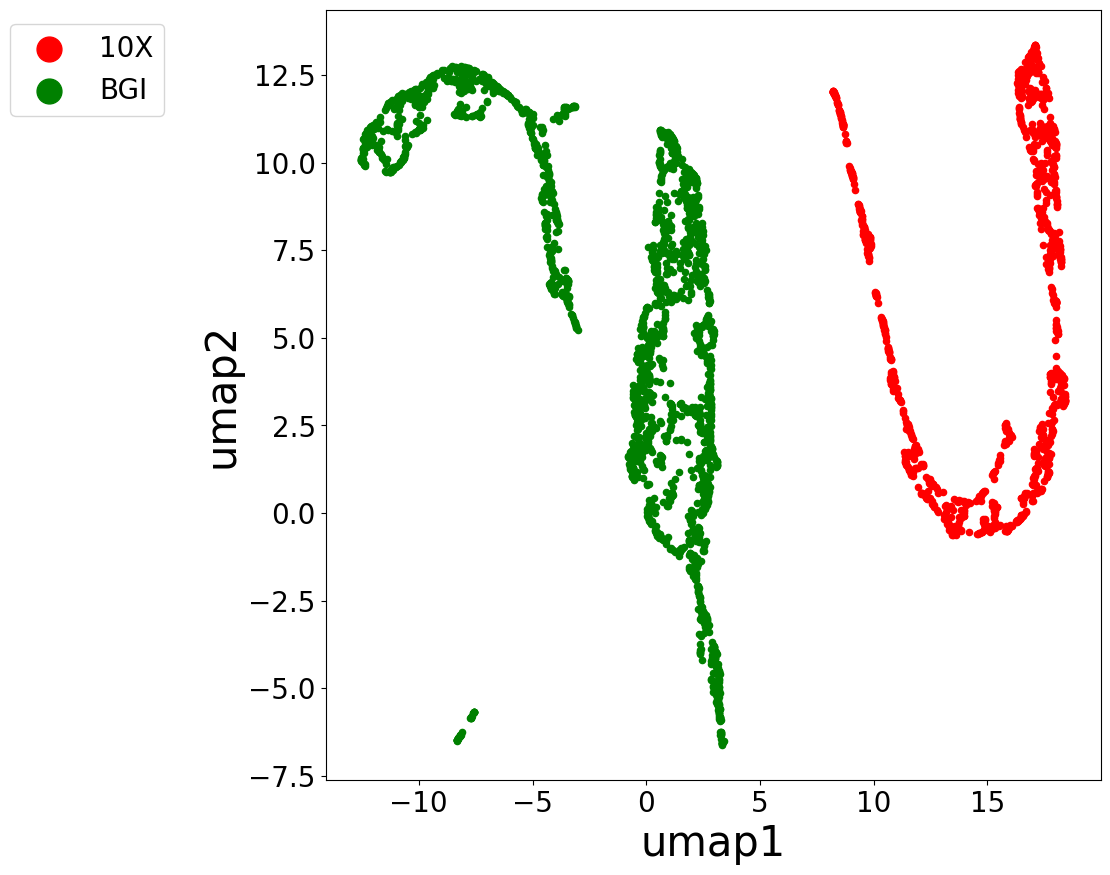

In [17]:
# batch=adata.obs['batch_name'].values
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
umap_mat=umap.UMAP().fit_transform(embed.values)
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=20
for i in range(len(ub)):
    axs.scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)

axs.set_xlabel("umap1",fontsize=30)
axs.set_ylabel("umap2",fontsize=30)
axs.legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)


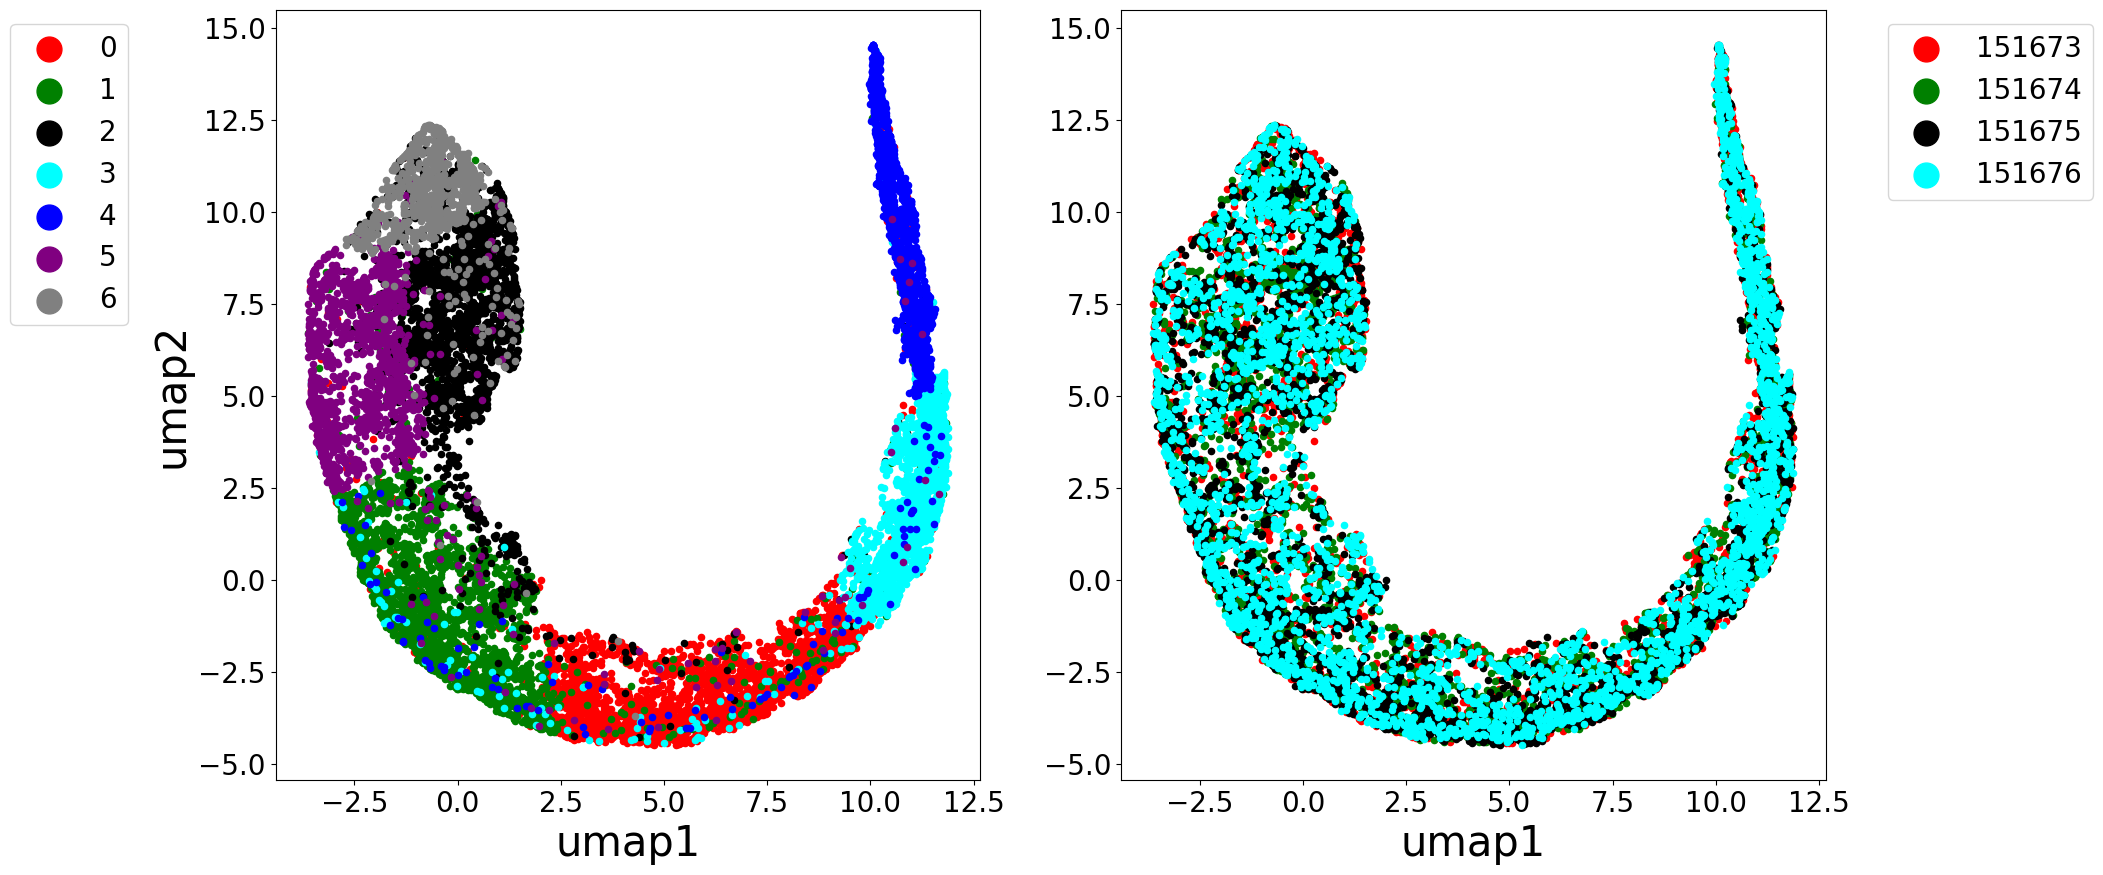

In [55]:
celltype=clust
ul=np.unique(celltype)
ub=np.unique(batch)
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour2[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/tguo/tguo2/miniconda3/envs/DeepST/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


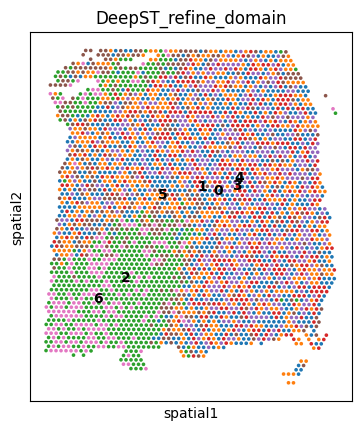

In [60]:
import scanpy as sc
size1=100
metric='DeepST_refine_domain'
ann1=adata[adata.obs['batch_name']==str(ub[0]),:]
sc.pl.spatial(ann1,color=metric, spot_size=100,legend_loc='on data')